<center><h1>Music recommendation using graphs</h1>
<h2>MLNS PROJECT</h2>
<h3>Coded by Chloé Daems, Amir Mahmoudi and Anne-Claire Laisney</h3>
</center>

This is the main notebook to create a benchmark of graph based music recommendation systems inspired by the *Katarya, R., Verma, O.P. Efficient music recommender system using context graph and particle swarm. Multimed Tools Appl 77, 2673–2687 (2018).* [paper](URL 'https://link.springer.com/article/10.1007/s11042-017-4447-x'), using data from the user.getRecentTracks of the [Last.fm](URL 'https://www.last.fm/api/show/user.getRecentTracks') API.

In [1]:
#Import the libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output

## Create the graph

**Get the dataset**

In [2]:
user_id_profile = pd.read_csv('lastfm-dataset-1K/userid-profile.tsv', sep = '\t')
logs_columns = ['userid', 'timestamp', 'artist-id', 'artist-name', 'track-id', 'track-name']
user_id_logs = pd.read_csv('lastfm-dataset-1K/userid-logs.tsv', sep = '\t', header = None, names =  logs_columns )

In [3]:
user_id_profile.head()

,#id,gender,age,country,registered
0,user_000001,m,NaN,Japan,"Aug 13, 2006"
1,user_000002,f,NaN,Peru,"Feb 24, 2006"
2,user_000003,m,22.0,United States,"Oct 30, 2005"
3,user_000004,f,NaN,NaN,"Apr 26, 2006"
4,user_000005,m,NaN,Bulgaria,"Jun 29, 2006"


In [4]:
user_id_logs.head()

,userid,timestamp,artist-id,artist-name,track-id,track-name
0,user_000001,2009-05-04T23:08:57Z,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1,user_000001,2009-05-04T13:54:10Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15)
2,user_000001,2009-05-04T13:52:04Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15)
3,user_000001,2009-05-04T13:42:52Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15)
4,user_000001,2009-05-04T13:42:11Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15)


**Let's only take the n most listened songs of each users**

In [5]:
def get_only_top(df_logs, n_top):
    new_df = pd.DataFrame(columns = ['track-name','artist-name'], dtype= np.str)
    for user_id in user_id_profile['#id'].values[:20]:
        test = user_id_logs[user_id_logs['userid']== user_id]
        test['count'] = test.groupby(['track-name', 'artist-name'])[['track-name', 'artist-name']].transform(lambda x: x.count())['track-name']
        test = test.sort_values(by = 'count', ascending = False)
        test = test.drop('timestamp', axis = 1)
        test = test.drop_duplicates()
        new_df = pd.concat([new_df, test[:n_top]], ignore_index=True)
        clear_output(wait = True)
        print("Juste finished for",user_id)
    return new_df


In [6]:
user_top_logs = get_only_top(user_id_logs, n_top = 20)
user_top_logs.head()

Juste finished for user_000020


,track-name,artist-name,userid,artist-id,track-id,count
0,Music,Cornelius,user_000001,df765d93-621c-437f-99fe-fda9e135f89a,af40062e-09fd-4d8f-84f3-47d7cfe7f98c,70.0
1,Gum,Cornelius,user_000001,df765d93-621c-437f-99fe-fda9e135f89a,672985dd-e599-4701-90c0-fe566db28349,63.0
2,Mario Basanov & Vidis ‘Test’,Gilles Peterson,user_000001,4c4e3121-4d12-4f7a-a77c-5becd849fb3c,NaN,52.0
3,Child Song,The Cinematic Orchestra,user_000001,7c158ea8-c0aa-410e-bdc1-20bba9759577,ead433ca-a4d6-462b-af46-afafe9b0f4ad,45.0
4,Hibari,坂本龍一,user_000001,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,213837d4-0582-49f0-9e45-977f92918323,42.0


**Transform the dataset into a multilayer graph**

In [7]:
G= nx.Graph()
color_list = []
edges = np.array(user_top_logs[['userid', 'track-name', 'artist-name']].values)
lastuser = ""
musics = []
artists = []
for edge in edges:
    G.add_node(edge[0])
    G.add_node(edge[1])
    G.add_node(edge[2])

    if lastuser != edge[0]:
        color_list.append('red')
        lastuser = edge[0]

    if edge[1] not in musics:
        musics.append(edge[1])
        color_list.append("blue")
    
    if edge[2] not in artists:
        artists.append(edge[2])
        color_list.append("green")

        
G.add_edges_from(edges[:,:-1])
G.add_edges_from(edges[:,1:])


In [8]:
len(G.nodes)

627

In [9]:
len(color_list)

627

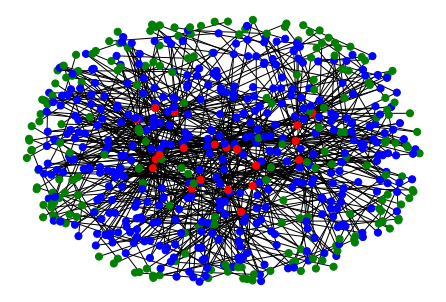

In [10]:
pos = nx.spring_layout(G, k=0.3, iterations = 45)
nx.draw(G,node_color=color_list, with_labels=False, pos = pos, node_size=50)
plt.show()

In [11]:
from colorama import Fore
new_list = list(G.degree())
new_list.sort(key=lambda y: y[1])
for node, degree in new_list:
    if node in artists:
        print(Fore.GREEN + "(" + node + "," + str(degree)+")")
    elif node in musics:
        print(Fore.BLUE + "(" + node + "," + str(degree)+")")
    else:
        print(Fore.RED + "(" + node + "," + str(degree)+")")


(Gilles Peterson,1)
(A Hundred Birds,1)
(Rasmus Faber,1)
(Damien Rice,1)
(Death Cab For Cutie,1)
(Brand New,1)
(Colin Hay,1)
(M.I.A.,1)
(Chromeo,1)
(Digitalism,1)
(Cunninlynguists,1)
(Sublime,1)
(Shiny Toy Guns,1)
(Anni Rossi,1)
(Simon & Garfunkel,1)
(Olivia Inspi' Reira (Trapnest),1)
(The Cliks,1)
(Morphine,1)
(Tender Forever,1)
(Taxi Taxi!,1)
(Alu,1)
(Great Lake Swimmers,1)
(Planet Club - Winter Edition -,1)
(Mylo,1)
(David Guetta,1)
(Röyksopp,1)
(Gabriel & Dresden,1)
(Erick Morillo & P. Diddy,1)
(José González,1)
(Freeform Five,1)
(Chocolate Puma,1)
(Apparat,1)
(Modjo,1)
(П.Т.В.П.,1)
(Kaliber,1)
(Ёлочные Игрушки + Чикис,1)
(Nancy Sinatra,1)
(Jane Air,1)
(Nirvana,1)
(We Bleed Charisma,1)
(Ladytron,1)
(Loose Ends,1)
(E-40 Feat T-Pain,1)
(Dwele,1)
(D4L,1)
(Baby D,1)
(Donell Jones,1)
(Kelis & Too $Hort,1)
(Brooke Valentine,1)
(Remy Shand,1)
(Anberlin,1)
(Djuma Soundsystem,1)
(Bullet For My Valentine,1)
(Oceanlab,1)
(Him,1)
(The Birthday Massacre,1)
(The Prodigy,1)
(Mims,1)
(Robin Fox,1)